<a href="https://colab.research.google.com/github/sokrypton/algosb_2021/blob/main/Intro_to_AEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax
from jax.experimental.optimizers import adam

In [2]:
from sklearn.datasets import make_blobs

MSE = INVCOV

In [16]:
# make clusters
np.random.seed(0)
x,c = make_blobs(n_samples=100,n_features=50,centers=1)
x -= x.mean(0)

In [17]:
def model(params, inputs):
  x_ = inputs["x"] @ params["w"]
  loss = jnp.square(x_ - inputs["x"]).sum(-1).mean() - 2 * jnp.trace(params["w"])
  return loss

In [18]:
grad_model = jax.jit(jax.value_and_grad(model))

# initialize optimizer
init_fun, update_fun, get_params = adam(1e-2)

# initialize state
params = {"w":np.asarray(np.random.normal(0,0.1,size=(50,50)))}
inputs = {"x":jnp.asarray(x)}
state = init_fun(params)
for n in range(2000):
  loss, grad = grad_model(get_params(state), inputs)
  state = update_fun(n, grad, state)
  if (n+1) % 100 == 0:
    print(n+1,loss)

100 -87.48536
200 -151.40872
300 -181.79523
400 -194.082
500 -198.3785
600 -199.70596
700 -200.0762
800 -200.17096
900 -200.19334
1000 -200.19818
1100 -200.19919
1200 -200.19933
1300 -200.1994
1400 -200.19936
1500 -200.19937
1600 -200.19934
1700 -200.19939
1800 -200.19937
1900 -200.19939
2000 -200.1994


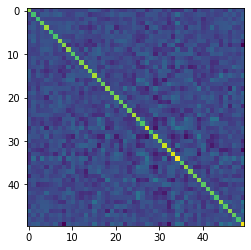

In [19]:
plt.imshow(get_params(state)["w"])

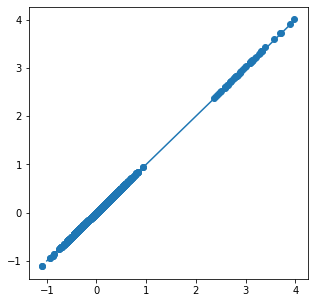

In [20]:
w_analytical = jnp.linalg.inv(jnp.cov(x.T)) + jnp.eye(50)
plt.figure(figsize=(5,5))
plt.scatter(w_analytical, get_params(state)["w"])
plt.plot([-1,4],[-1,4])
plt.show()

Linear Autoencoders = PCA

In [25]:
def model(params, inputs):
  x_ = inputs["x"] @ params["w"] @ params["w"].T
  loss = jnp.square(x_ - inputs["x"]).sum(-1).mean()
  return loss

In [26]:
grad_model = jax.jit(jax.value_and_grad(model))

# initialize optimizer
init_fun, update_fun, get_params = adam(1e-2)

# initialize state
params = {"w":jnp.asarray(np.random.normal(0,0.1,size=(50,2)))}
inputs = {"x":jnp.asarray(x)}
state = init_fun(params)
for n in range(2000):
  loss, grad = grad_model(get_params(state), inputs)
  state = update_fun(n, grad, state)
  if (n+1) % 100 == 0:
    print(n+1,loss)

100 42.86858
200 42.825684
300 42.82495
400 42.82494
500 42.82494
600 42.82494
700 42.824944
800 42.824944
900 42.824944
1000 42.824944
1100 42.824944
1200 42.824944
1300 42.82494
1400 42.824944
1500 42.82494
1600 42.824944
1700 42.82494
1800 42.824944
1900 42.824944
2000 42.82494


In [27]:
from sklearn.decomposition import PCA

In [28]:
pca = PCA(2).fit(x)

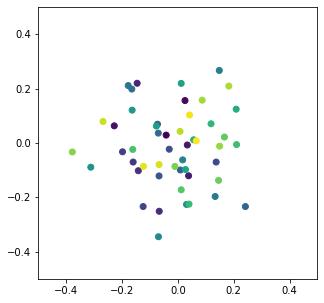

In [29]:
plt.figure(figsize=(5,5))
plt.scatter(get_params(state)["w"][:,0],
            get_params(state)["w"][:,1],
            c=np.arange(50))
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.show()

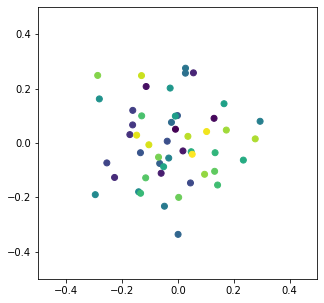

In [30]:
plt.figure(figsize=(5,5))
plt.scatter(pca.components_[0],
            pca.components_[1],
            c=np.arange(50))
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.show()

Categorical AE == KMEANS

In [32]:
# make clusters
np.random.seed(0)
x,c = make_blobs(n_samples=1000,n_features=50,centers=4)
x -= x.mean(0)

In [33]:
def model(params, inputs):
  z = jax.nn.softmax(inputs["x"] @ params["w"])
  z = jax.lax.stop_gradient(jax.nn.one_hot(z.argmax(-1),params["w"].shape[1]) - z) + z
  x_ = z @ params["w"].T
  loss = jnp.square(x_ - inputs["x"]).sum(-1).mean()
  return loss

In [38]:
grad_model = jax.jit(jax.value_and_grad(model))

# initialize optimizer
init_fun, update_fun, get_params = adam(1e-2)

# initialize state
params = {"w":jnp.asarray(np.random.normal(size=(50,4)))}
inputs = {"x":jnp.asarray(x)}
state = init_fun(params)
for n in range(4000):
  loss, grad = grad_model(get_params(state), inputs)
  state = update_fun(n, grad, state)
  if (n+1) % 1000 == 0:
    print(n+1,loss)

1000 82.18846
2000 49.741554
3000 49.488213
4000 49.488026


In [35]:
from sklearn.cluster import KMeans

In [36]:
kmeans = KMeans(4,n_init=100).fit(x)

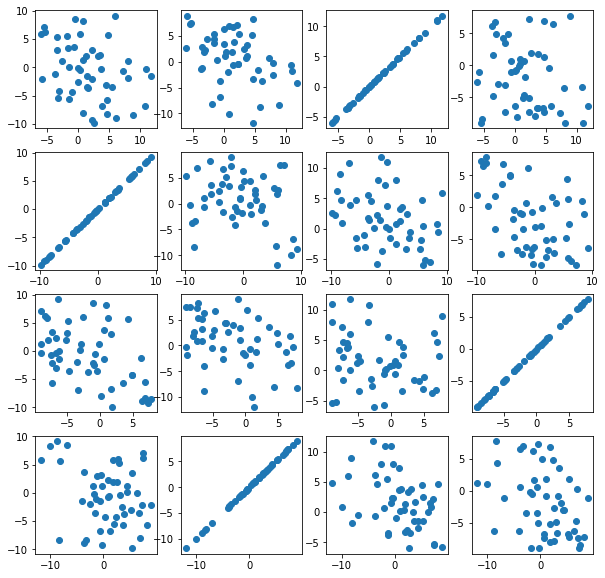

In [39]:
plt.figure(figsize=(10,10))
k = 1
for i in range(4):
  for j in range(4):
    plt.subplot(4,4,k)
    plt.scatter(kmeans.cluster_centers_[i],
                get_params(state)["w"][:,j])
    k += 1
plt.show()